In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

In [3]:
from data_load import *
import Exp7

In [4]:
class Stuff: pass

def one_dot_one_scat(method):
    '''Return performance statistics of the supercategory finding method, from the point of view of one class'''
    #Results per supercategory
    stats = pd.DataFrame(columns=['TP', 'TN', 'FP', 'FN', 'Precision', 'Recall'], index=sorted(known_supercategories))
    perf = {}
    scat2yks = Exp7.results[method+'/scat2yks']
    for scat in known_supercategories:
        res = Stuff()
        res.pos = supercategory2years_keys[scat]  # All ground truth positives
        res.tp = scat2yks[scat] & supercategory2years_keys[scat]  # True positives
        res.fp = scat2yks[scat] - supercategory2years_keys[scat]  # False positives
        res.neg = all_yks - supercategory2years_keys[scat]  # All ground truth negatives
        res.tn = (all_yks - supercategory2years_keys[scat]) & (all_yks - scat2yks[scat])  # True negatives
        res.fn = supercategory2years_keys[scat] - scat2yks[scat]  # False negatives
        assert res.pos == res.tp | res.fn
        #print(res.neg, res.tn, res.fp)
        assert res.neg == res.tn | res.fp
        assert scat2yks[scat] == res.tp | res.fp
        assert all_yks - scat2yks[scat] == res.tn | res.fn
        perf[scat] = res
        if len(res.tp) > 0:
            stats.loc[scat,:] = list(map(len,[res.tp, res.tn, res.fp, res.fn])) + [len(res.tp)/(len(res.tp)+len(res.fp)), 
                                                                        len(res.tp)/(len(res.tp)+len(res.fn))]
        else:
            stats.loc[scat,:] = list(map(len,[res.tp, res.tn, res.fp, res.fn])) + [0,0]
    return perf, stats

In [5]:
def one_dot_one_firm(method):
    '''Return performance statistics of the method, from the point of view of one firm'''
    #Results per supercategory
    stats = pd.DataFrame(columns=['TP', 'TN', 'FP', 'FN', 'Precision', 'Recall'], index=sorted(all_yks, key=lambda yk:yk[1]))
    perf = {}
    yk2scats = Exp7.results[method+'/yk2scats']
    for yk in [yk for yk in all_yks if len(year_key2supercategories[yk])>0]:
        res = Stuff()
        res.pos = year_key2supercategories[yk]  # All ground truth positives
        res.tp = yk2scats[yk] & year_key2supercategories[yk]  # True positives
        res.fp = yk2scats[yk] - year_key2supercategories[yk]  # False positives
        res.neg = known_supercategories - year_key2supercategories[yk]  # All ground truth negatives
        res.tn = (known_supercategories - year_key2supercategories[yk]) & (known_supercategories - yk2scats[yk])  # True negatives
        res.fn = year_key2supercategories[yk] - yk2scats[yk]  # False negatives
        assert res.pos == res.tp | res.fn
        #print(res.neg, res.tn, res.fp)
        assert res.neg == res.tn | res.fp
        assert yk2scats[yk] == res.tp | res.fp
        assert known_supercategories - yk2scats[yk] == res.tn | res.fn
        perf[yk] = res
        if len(res.tp) > 0:
            stats.loc[yk,:] = list(map(len,[res.tp, res.tn, res.fp, res.fn])) + [len(res.tp)/(len(res.tp)+len(res.fp)), 
                                                                        len(res.tp)/(len(res.tp)+len(res.fn))]
        else:
            stats.loc[yk,:] = list(map(len,[res.tp, res.tn, res.fp, res.fn])) + [0,0]
    return perf, stats

In [6]:
def totals(stats):
    '''Compute the total number of FP, FN, TN, TP'''
    tp = stats['TP'].sum()
    tn = stats['TN'].sum()
    fp = stats['FP'].sum()
    fn = stats['FN'].sum()
    return tp, tn, fp, fn

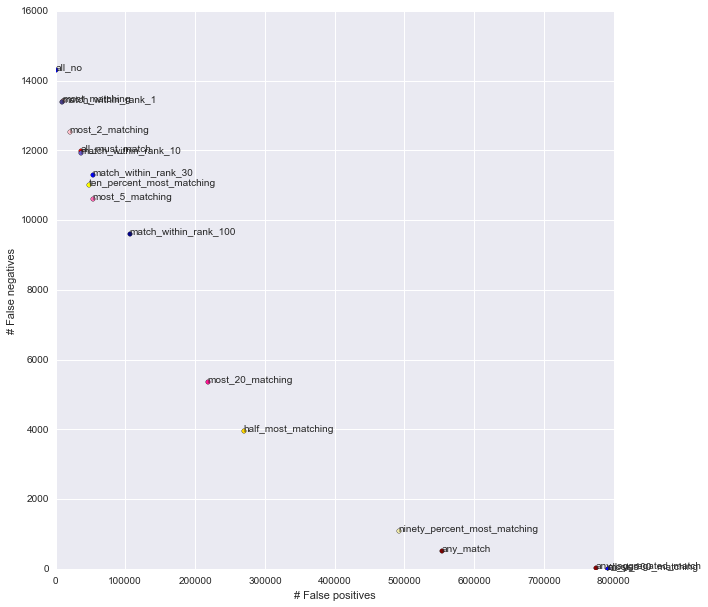

In [10]:
plt.figure(figsize=(10,10))
plt.xlabel('# False positives')
plt.ylabel('# False negatives')
for method, color in zip(Exp7.results['methods'], Exp7.results['colors']):
    tp, tn, fp, fn = totals(one_dot_one_scat(method)[1])
    assert (tp, tn, fp, fn) == totals(one_dot_one_firm(method)[1]), 'Total numbers should be equal for both method of counting'
    plt.scatter(fp, fn, c=color)
    plt.text(fp, fn, method)
# Now computing the number of FN for the strategy that always answers no
all_no_fn = sum(map(len, supercategory2years_keys.values()))
assert all_no_fn == sum(map(len, year_key2supercategories.values()))
plt.scatter(0, all_no_fn, c='blue')
plt.text(0, all_no_fn, 'all_no')
# and now the number of FP for the strategy that would always answers yes
all_yes_fp = len(all_yks)*len(known_supercategories) - all_no_fn
plt.scatter(all_yes_fp, 0, c='blue')
plt.text(all_yes_fp, 0, 'all_yes')
plt.xlim(0, 80000)
plt.ylim(0, 16000)
plt.savefig('Exp7.pdf')

In [10]:
all_yes_fp, all_no_fn

(791701, 14291)

In [13]:
def one_dot_one_cat(method):
    '''Return performance statistics of the sub-cat finding method, from the point of view of one class'''
    #Results per category
    stats = pd.DataFrame(columns=['TP', 'TN', 'FP', 'FN', 'Precision', 'Recall'], index=sorted(known_categories))
    perf = {}
    cat2yks = Exp7.results[method+'/cat2yks']
    for cat in known_categories:
        possible_yks = set([yk for yk in all_yks if supercat(cat) in year_key2supercategories[yk]])
        res = Stuff()
        res.pos = category2years_keys[cat]  # All ground truth positives
        res.tp = cat2yks[cat] & category2years_keys[cat]  # True positives
        res.fp = cat2yks[cat] - category2years_keys[cat]  # False positives
        res.neg = possible_yks - category2years_keys[cat]  # All ground truth negatives
        res.tn = (possible_yks - category2years_keys[cat]) & (possible_yks - cat2yks[cat])  # True negatives
        res.fn = category2years_keys[cat] - cat2yks[cat]  # False negatives
        assert res.pos == res.tp | res.fn
        #print(res.neg, res.tn, res.fp)
        assert res.neg == res.tn | res.fp
        assert cat2yks[cat] == res.tp | res.fp
        assert possible_yks - cat2yks[cat] == res.tn | res.fn
        perf[cat] = res
        if len(res.tp) > 0:
            stats.loc[cat,:] = list(map(len,[res.tp, res.tn, res.fp, res.fn])) + [len(res.tp)/(len(res.tp)+len(res.fp)), 
                                                                        len(res.tp)/(len(res.tp)+len(res.fn))]
        else:
            stats.loc[cat,:] = list(map(len,[res.tp, res.tn, res.fp, res.fn])) + [0,0]
    return perf, stats

In [14]:
def one_dot_one_firm_sub(method):
    '''Return performance statistics of the method knowing the super, from the point of view of one firm'''
    #Results per supercategory
    stats = pd.DataFrame(columns=['TP', 'TN', 'FP', 'FN', 'Precision', 'Recall'], index=sorted(all_yks, key=lambda yk:yk[1]))
    perf = {}
    yk2cats = Exp7.results[method+'/yk2cats']
    for yk in [yk for yk in all_yks if len(year_key2categories[yk])>0]:
        possible_categories = set([c for c in known_categories if supercat(c) in year_key2supercategories[yk]])
        res = Stuff()
        res.pos = year_key2categories[yk]  # All ground truth positives
        res.tp = yk2cats[yk] & year_key2categories[yk]  # True positives
        res.fp = yk2cats[yk] - year_key2categories[yk]  # False positives
        res.neg = possible_categories - year_key2categories[yk]  # All ground truth negatives
        res.tn = (possible_categories - year_key2categories[yk]) & (possible_categories - yk2cats[yk])  # True negatives
        res.fn = year_key2categories[yk] - yk2cats[yk]  # False negatives
        assert res.pos == res.tp | res.fn
        #print(res.neg, res.tn, res.fp)
        assert res.neg == res.tn | res.fp
        assert yk2cats[yk] == res.tp | res.fp
        assert possible_categories - yk2cats[yk] == res.tn | res.fn
        perf[yk] = res
        if len(res.tp) > 0:
            stats.loc[yk,:] = list(map(len,[res.tp, res.tn, res.fp, res.fn])) + [len(res.tp)/(len(res.tp)+len(res.fp)), 
                                                                        len(res.tp)/(len(res.tp)+len(res.fn))]
        else:
            stats.loc[yk,:] = list(map(len,[res.tp, res.tn, res.fp, res.fn])) + [0,0]
    return perf, stats

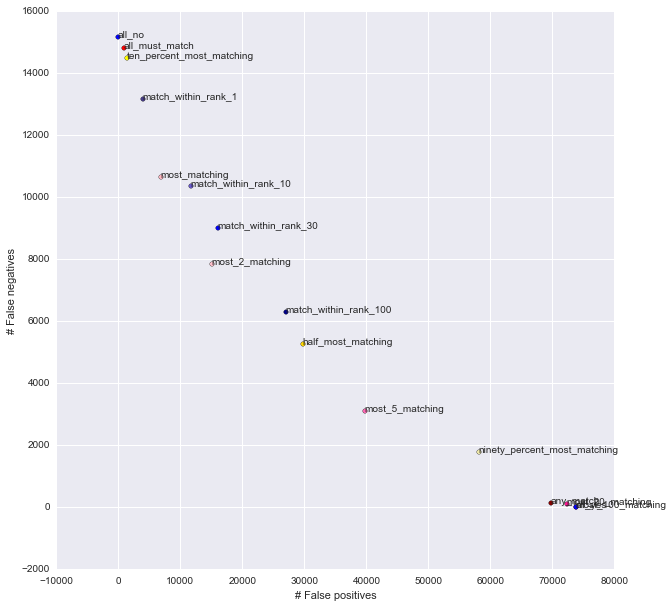

In [19]:
plt.figure(figsize=(10,10))
plt.xlabel('# False positives')
plt.ylabel('# False negatives')
for method, color in zip([m for m in Exp7.results['methods'] if m != 'any_aggregated_match'], [c for c in Exp7.results['colors'] if c!= 'maroon']):
    tp, tn, fp, fn = totals(one_dot_one_cat(method)[1])
    assert (tp, tn, fp, fn) == totals(one_dot_one_firm_sub(method)[1]), 'Total numbers should be equal for both method of counting'
    plt.scatter(fp, fn, c=color)
    plt.text(fp, fn, method)
# Now computing the number of FN for the 'always' strategies
all_yes_fp = 0
all_no_fn = 0
for yk in [yk for yk in all_yks if len(year_key2categories[yk])>0]:
    all_no_fn += len(year_key2categories[yk])
    possible_categories = [c for c in known_categories if supercat(c) in year_key2supercategories[yk]]
    all_yes_fp += len(possible_categories) - len(year_key2categories[yk])
plt.scatter(0, all_no_fn, c='blue')
plt.text(0, all_no_fn, 'all_no')
plt.scatter(all_yes_fp, 0, c='blue')
plt.text(all_yes_fp, 0, 'all_yes')
#plt.xlim(0, 80000)
#plt.ylim(0, 16000)
plt.savefig('Exp7_sub.pdf')

In [18]:
all_yes_fp, all_no_fn

(73757, 15153)

In [ ]:
stat_1

In [ ]:
stat_2

In [30]:
_, stat_1 = one_dot_one_scat('all_must_match')
_, stat_2 = one_dot_one_firm('all_must_match')
totals(stat_1),totals(stat_2)

((2317, 754878, 36823, 11974), (2317, 754878, 36823, 11974))

In [11]:
for method_str, color in zip(results['methods'],['blue', 'pink', 'red', 'orange', 'yellow', 'green', 'pink', 'hotpink',
                                                        'magenta', 'purple']):
    t = one_dot_one_scat(method_str)[1]
    plt.figure()
    plt.scatter(t['Recall'], t['Precision'], c=color)
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(method_str)

NameError: name 'all_yciks' is not defined

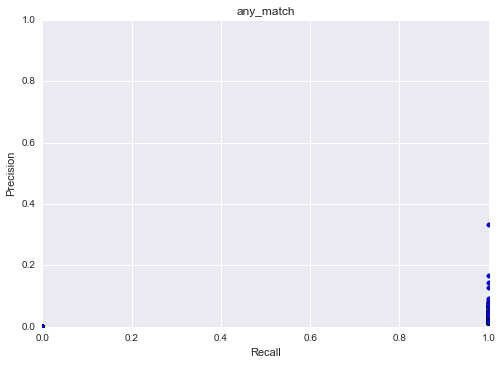

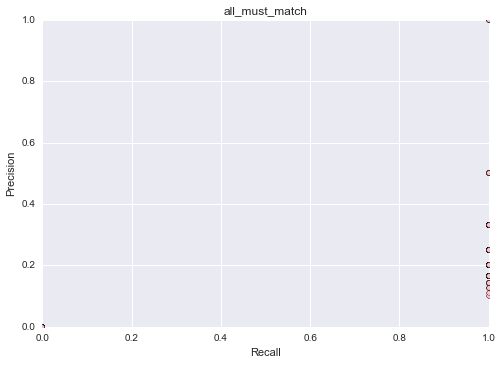

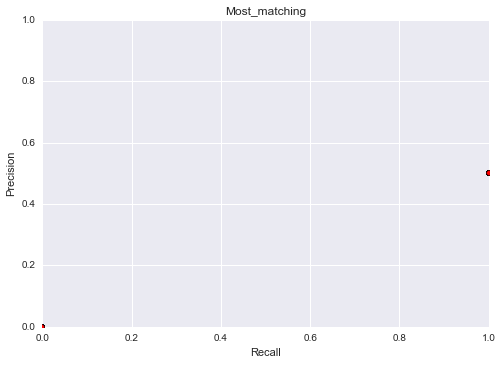

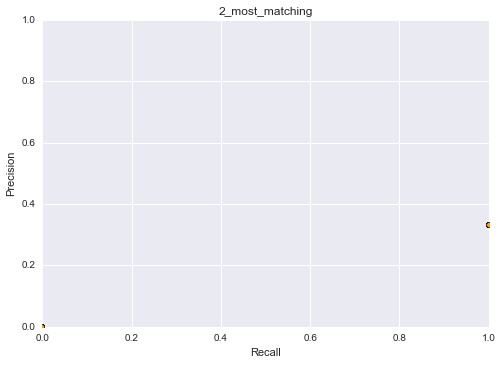

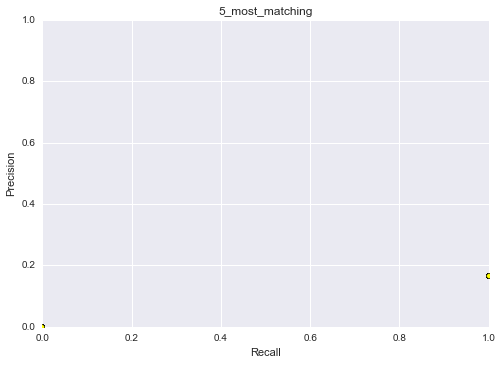

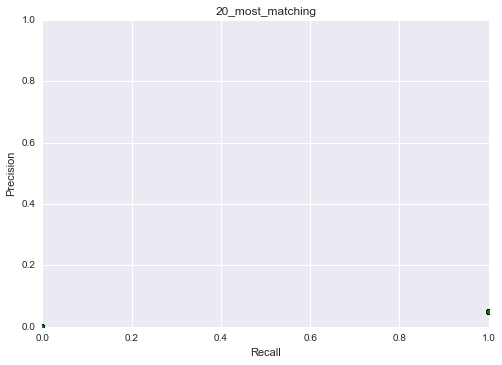

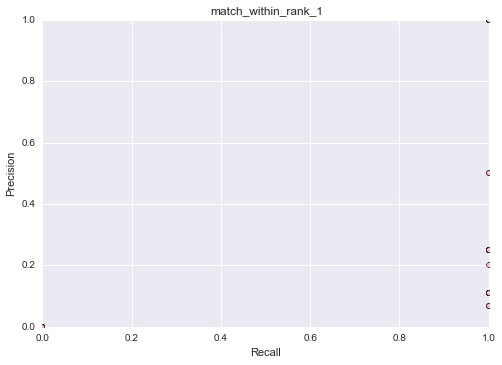

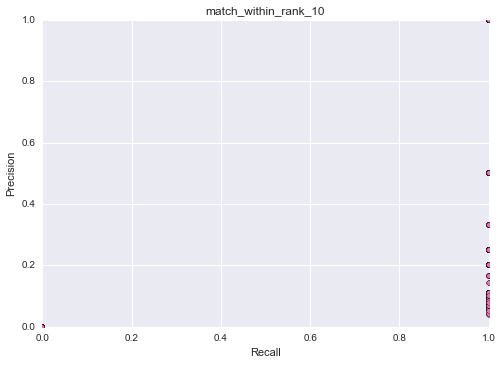

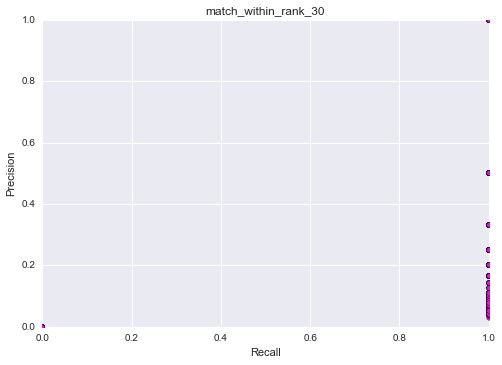

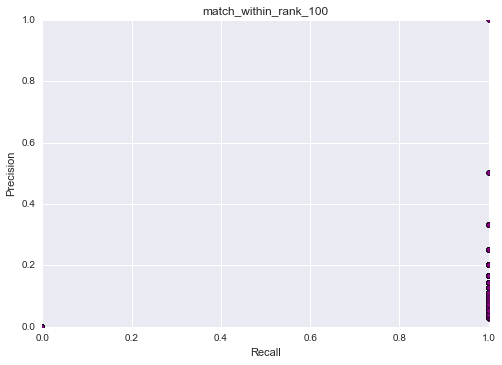

In [9]:
for method_str, color in zip(['any_match', 'all_must_match', 'Most_matching', '2_most_matching', '5_most_matching', 
                              '20_most_matching', 'match_within_rank_1', 'match_within_rank_10', 'match_within_rank_30',
                              'match_within_rank_100'],['blue', 'pink', 'red', 'orange', 'yellow', 'green', 'pink', 'hotpink',
                                                        'magenta', 'purple']):
    t = one_dot_one_firm(method_str)[1]
    plt.figure()
    plt.scatter(t['Recall'], t['Precision'], c=color)
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(method_str)

In [15]:
missing_industries = set([515, 518, 11, 16, 21, 27, 542, 543, 544, 546, 549, 559, 564, 74, 75, 76, 78, 592, 81, 83, 85, 608, 106, 108, 622, 623, 124, 637, 639, 132, 141, 654, 144, 145, 147, 149, 671, 672, 539, 172, 174, 175, 176, 177, 178, 722, 211, 212, 213, 726, 732, 223, 224, 226, 231, 234, 235, 241, 754, 249, 762, 769, 811, 214, 277, 278, 792, 295, 299, 301, 305, 311, 313, 829, 319, 832, 321, 328, 334, 339, 864, 869, 899, 396, 922, 412, 413, 415, 443, 458, 478, 496, 497, 502])
len(category2years_ciks.keys()) - len(all_categories) + len(all_supercategories), len(missing_industries)

(-169, 94)

In [22]:
test = [a for a in year_cik2categories.items()][:100]
test
#603 in category2years_ciks

[((1998, 836106), {355}),
 ((1998, 880117), {206}),
 ((1999, 903571), {104}),
 ((1998, 351710), {602}),
 ((1998, 908179), {202}),
 ((1999, 1003022), {367}),
 ((1999, 1067701), {735}),
 ((1998, 848551), {737}),
 ((1998, 1027974), {632}),
 ((1998, 806011), {356}),
 ((1998, 1041333), {737}),
 ((1999, 82020), {142}),
 ((1999, 1029281), {874}),
 ((1998, 46109), {359}),
 ((1999, 854662), {603}),
 ((1999, 947484), {633}),
 ((1999, 913782), {679}),
 ((1999, 857005), {737}),
 ((1998, 1026655), {308}),
 ((1998, 919568), {603}),
 ((1999, 801529), {386}),
 ((1998, 852772), {581}),
 ((1999, 917470), {505}),
 ((1999, 868373), {357}),
 ((1999, 49728), {367}),
 ((1999, 1009386), {737}),
 ((1998, 858470), {131}),
 ((1998, 809875), {283}),
 ((1999, 101382), {602}),
 ((1998, 77551), {382}),
 ((1999, 86759), {679}),
 ((1999, 5513), {632}),
 ((1999, 1005508), {603}),
 ((1999, 948846), {451}),
 ((1999, 867493), {603}),
 ((1999, 883984), {384}),
 ((1999, 746481), {602}),
 ((1999, 714395), {602}),
 ((1999, 10

In [11]:
_one_dot_one_firm('any_match')[1]

,TP,TN,FP,FN,Precision,Recall
"(1999, 20)",1,30,52,0,0.01886792,1
"(1998, 20)",1,30,52,0,0.01886792,1
"(1998, 1750)",0,31,51,1,0,0
"(1999, 1923)",1,40,42,0,0.02325581,1
"(1998, 2098)",0,51,31,1,0,0
"(1999, 2098)",0,53,29,1,0,0
"(1999, 2178)",1,13,69,0,0.01428571,1
"(1998, 2178)",1,13,69,0,0.01428571,1
"(1999, 2186)",1,39,43,0,0.02272727,1
"(1998, 2589)",1,31,51,0,0.01923077,1
